In [134]:
# !pip install xgboost
# !pip install -U imbalanced-learn
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

In [135]:
## ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [136]:
application_record = pd.read_csv('/Users/wongzhiyuan/CS3244-Project/src/static/application_record.csv')
credit_record = pd.read_csv('/Users/wongzhiyuan/CS3244-Project/src/static/credit_record.csv')

## Data Labelling and Data Cleaning

We need to label the data that is deemed to be defaulters and data that are not defaulters. The crtieria that we set is if the borrower takes longer than 29 days, he / she will be classified as "bad" 


According to the data card: 
- 0: 1-29 days past due 
- 1: 30-59 days past due 
- 2: 60-89 days overdue 
- 3: 90-119 days overdue 
- 4: 120-149 days overdue 
- 5: Overdue or bad debts, write-offs for more than 150 days 
- C: paid off that month X: No loan for the month


Therefore, for our purposes we will only classify a customer is good if and only if they do not have statuses between 1 and 5 inclusive. 

<AxesSubplot: ylabel='Frequency'>

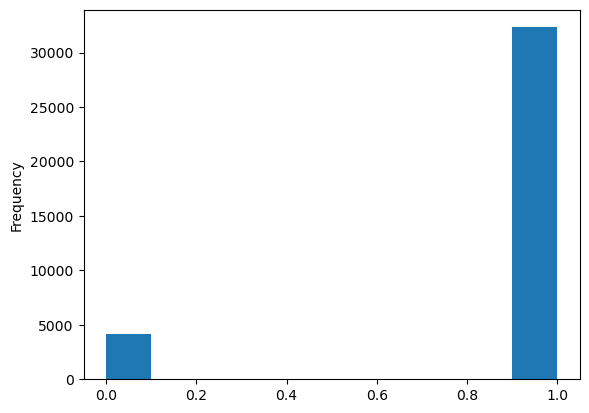

In [137]:
## Label the ID to their corresponding labels 
## Good: 1, Bad: 0 

#Helper functions
def label(row):
    '''
    labels the rows if they are good or bad
    using the above criteria 
    '''
    if row['STATUS'] == 'C' or row['STATUS'] == '0' or row['STATUS'] == 'x':
        return 1
    else:
        return 0 
def filter_groups(group):
    '''
    Removed any of the groups that did not have 0 in their months
    this indicates that while their application data is recent 
    their credit history is not 
    '''
    # return (group['MONTHS_BALANCE'] != 0).any()
    return True
    

def helper(row):
    '''
    Credit csv contains multiple rows with the same ID
    for the same ID some of the labels are good/bad depending on the month
    for each ID we classify them as good or bad by taking the average of the labels
    then setting the threshold to be 1
    '''
    if row['Label'] < 0.20 :  # Hyperparameter to be tuned
        return 0
    return 1 

# Label the ID in credit csv
credit_record['Label'] = credit_record.apply(label, axis = 1 )

# Group the credit data by ID 
grouped_credit = credit_record.groupby('ID')

# Create a new DataFrame containing groups where 'MONTH_BALANCE' doesn't contain 0
filtered_df = grouped_credit .filter(filter_groups)

# Reset the index of the filtered DataFrame
filtered_df = filtered_df.reset_index(drop=True)

#Aggregation for each of the ID to determine if they are good or bad overall
filtered_groupby = filtered_df.groupby('ID')['Label'].mean().reset_index()
filtered_groupby.columns = ['ID', 'Label']
filtered_groupby['Label'] = filtered_groupby.apply(helper, axis = 1)

# Combine the credit data with application data.
df = application_record.merge(filtered_groupby, on='ID', how='left')
df = df.dropna(subset=['Label'])
df['Label'].plot.hist()


We can observe that there is some imbalances in the data, but the imbalances are not too bad, we continue with the data cleaning below. We want to remove certain columns that are not useful and find the distribution of the remaining column data

In [138]:
# Clean Occupation Type. For individuals who are Pensioner and their occupation is NA, we change it to 'Retired'
df.loc[(df['OCCUPATION_TYPE'].isna()) & (df['NAME_INCOME_TYPE'] == 'Pensioner'), 'OCCUPATION_TYPE'] = 'Retired'

# Columns containing qualitative data
qualitative = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','CNT_CHILDREN','NAME_INCOME_TYPE',
               'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE']

# Change Qualitative Variables to their dummy indicator.
def encoding_helper(df:pd.DataFrame, columns: list[str]):
    '''
    Loops through the list of qualitative columns, then encodes them
    //I think there is a better way but im lazy to go find it 
    //Our dataset is quite small anyway
    //take note that cache lets us find the mappings later 
    '''
    cache = {}
    for column in columns: 
        mapping = {value : index for index, value in enumerate(df[column].unique())}
        cache[column] = mapping 
        df[column] = df[column].map(mapping)
    
    return df ,cache

df, cache = encoding_helper(df, qualitative)



# Correlation Matrix 

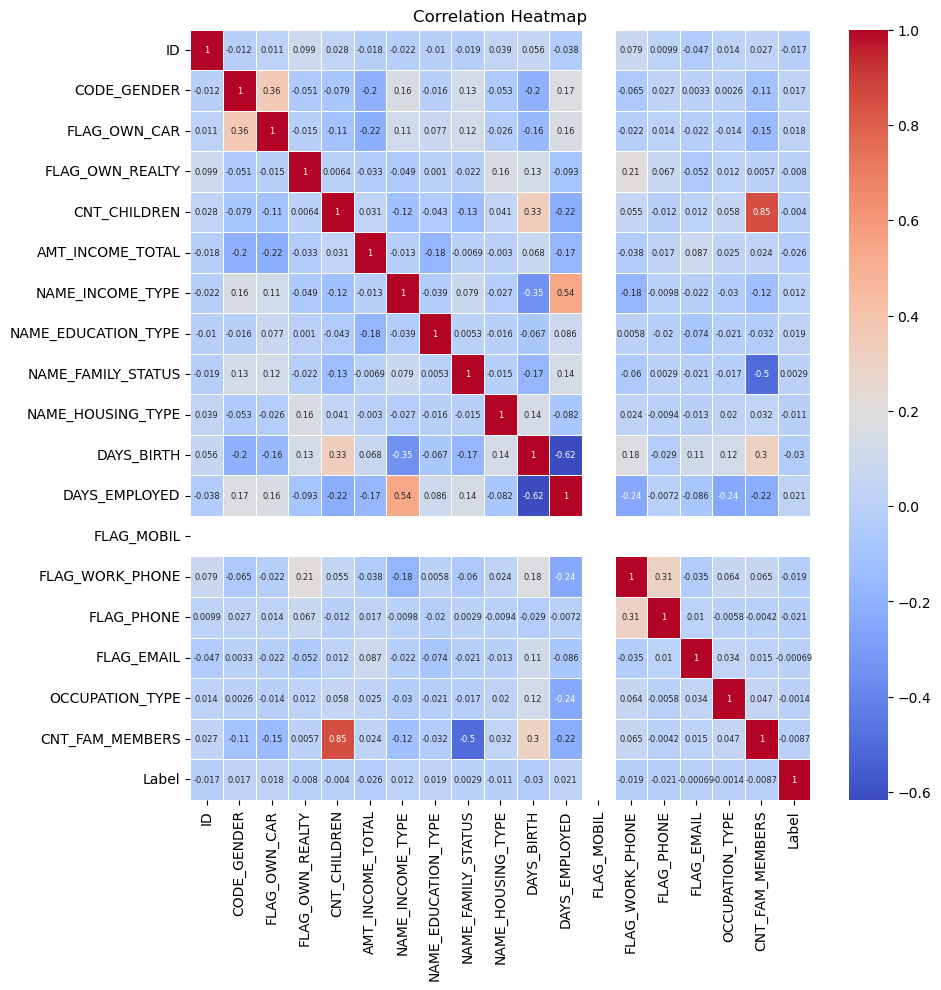

In [139]:
corr_matrix = df.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
for text in heatmap.texts:
    text.set_fontsize(6) 
plt.title('Correlation Heatmap')
plt.show()

In [140]:
# Dropping the columns that are inconsequential in our code
drop_columns = ['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL']
df = df.drop(columns = drop_columns)

# Making Cleaning up the days for DAYS_BIRTH and DAYS_Employed columns 
def days_helper(df:pd.DataFrame, columns :list[int]):
    '''
    Since the age and employed days are in days, we change it to years for better interpretability 
    for the employed column, if the value is negative, it indicated unemployement for x number of days
    '''
    for column in columns:
        df[column] = -df[column]/365
    
    return df 

date_columns = ['DAYS_BIRTH','DAYS_EMPLOYED']

df = days_helper(df, date_columns)


In [141]:
# Renaming of the DataFrame for easier access 
new_names = {'CODE_GENDER' : "gender","FLAG_OWN_CAR":'car','FLAG_OWN_REALTY':'property','CNT_CHILDREN':'number of children','AMT_INCOME_TOTAL': 'income',
             'NAME_INCOME_TYPE': 'income type','NAME_EDUCATION_TYPE':'education','NAME_FAMILY_STATUS':'marital status','NAME_HOUSING_TYPE':'housing type',
             'DAYS_BIRTH':'age','DAYS_EMPLOYED':'years employed','OCCUPATION_TYPE':'occupation','CNT_FAM_MEMBERS':'number of family members','Label':'class'}

df = df.rename(columns = new_names)

In [142]:
df

,ID,gender,car,property,number of children,income,income type,education,marital status,housing type,age,years employed,occupation,number of family members,class
0,5008804,0,0,0,0,427500.0,0,0,0,0,32.890411,12.443836,0,2.0,1.0
1,5008805,0,0,0,0,427500.0,0,0,0,0,32.890411,12.443836,0,2.0,1.0
2,5008806,0,0,0,0,112500.0,0,1,1,1,58.832877,3.106849,1,2.0,1.0
3,5008808,1,1,0,0,270000.0,1,1,2,1,52.356164,8.358904,2,1.0,1.0
4,5008809,1,1,0,0,270000.0,1,1,2,1,52.356164,8.358904,2,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434808,5149828,0,0,0,0,315000.0,0,1,1,1,47.528767,6.630137,6,2.0,0.0
434809,5149834,1,1,0,0,157500.0,1,0,1,1,33.936986,3.630137,14,2.0,1.0
434810,5149838,1,1,0,0,157500.0,2,0,1,1,33.936986,3.630137,14,2.0,1.0
434811,5150049,1,1,0,0,283500.0,0,1,1,1,49.200000,1.794521,2,2.0,1.0


In [143]:
# # Plot of the labels vs the individual features 

# # Split the DataFrame into two separate DataFrames based on the label values
# df_label_0 = df[df['class'] == 0]
# df_label_1 = df[df['class'] == 1]

# # Create a scatter plot for each feature
# for feature in df.columns[:-1]:  # Exclude the 'label' column
#     plt.figure(figsize=(8, 6))
#     plt.scatter(df_label_0[feature], df_label_0['class'], label='Label 0', color='blue', marker='o')
#     plt.scatter(df_label_1[feature], df_label_1['class'], label='Label 1', color='red', marker='x')
#     plt.xlabel(feature)
#     plt.ylabel('Label')
#     plt.title(f'Scatter Plot of {feature} vs Label')
#     plt.legend()
#     plt.show()

# Failure of scatterplots

We can observe that scatter plots does not work well for our dataset. This can be explained with the following reasons

1. Most of our variables are qualitative variables and we encode them with numerical variables. Since the variables are not quantitative anc continuous, we are not able to produce a good scatterplot of the data that we have on hand. 

2. There are only 2 binary classes, which will only be represented by two points. 

Given this, we are going to attempt to do feature selection without the use of scatter plots to evaluate our model. 

In [144]:
# # Create individual histograms for each column
# for column in df.columns:
#     fig = px.histogram(df, x=column, title=f'Histogram of {column}')
    
#     # Show each plot individually
#     fig.show()

# Data splitting 

In [153]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the Data from the DataFrame
X = df[['gender', 'car', 'property', 'number of children', 'income',
       'income type', 'education', 'marital status', 'housing type', 'age',
       'years employed', 'occupation', 'number of family members']]
y = df['class']

# Adjust for oversampling 

from imblearn.over_sampling import RandomOverSampler, SMOTE 

def balancing(X,y,type):
       '''
       This function helps us to choose the type of resampling that we 
       want to do, functional abstraction, 1010 things :-)
       '''
       ros = RandomOverSampler(random_state=42)
       smote = SMOTE(random_state=42)
       if type == 'oversample':
              return ros.fit_resample(X, y)
       else:
              return smote.fit_resample(X,y)


X_resampled, y_resampled = balancing(X,y,'smote')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.20, random_state = 42)

# Random Forest

In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

Accuracy: 0.9074245939675174
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      6566
         1.0       0.91      0.90      0.91      6364

    accuracy                           0.91     12930
   macro avg       0.91      0.91      0.91     12930
weighted avg       0.91      0.91      0.91     12930



<AxesSubplot: >

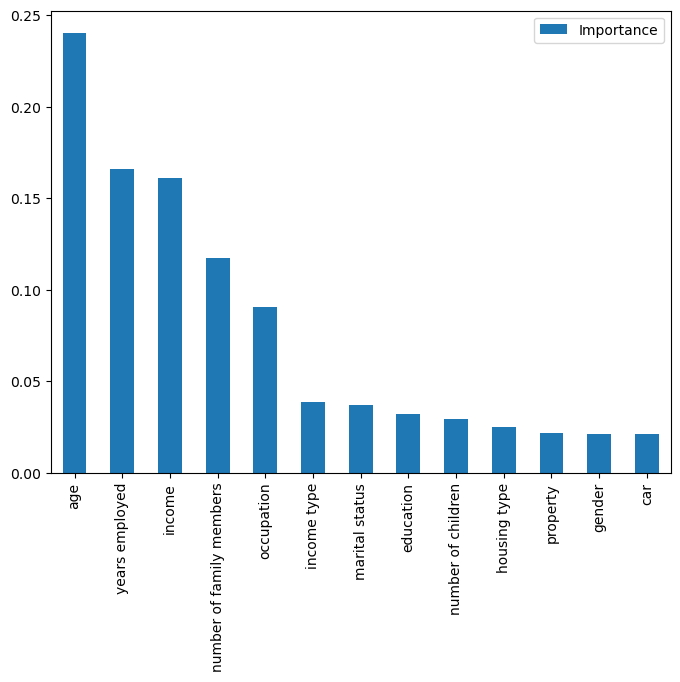

In [155]:
# Fit the RF model
clf = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap= True)

# Fit the model on the training data
clf.fit(X_train, y_train)

# Predict labels on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print a classification report
report = classification_report(y_test, y_pred)
print(report)

# Importance plot 

feat_importances = pd.DataFrame(clf.feature_importances_, index= X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

# Improvement 
We observe that we currently achieve about a 70% accuracy by simply throwing all the features into the model, in the next iteration to improve the model, we want to try to adjust for overfitting of the re


In [156]:
import xgboost as xgb

Accuracy: 0.8548337200309358


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

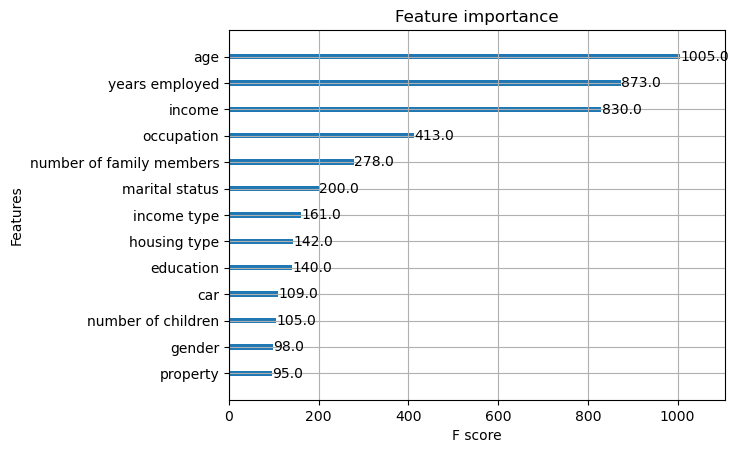

In [157]:
# Gradient boosted tree with xgboost

# specify parameters via map
xgb_model = xgb.XGBClassifier()

# Fit the model 
xgb_model.fit(X_train,y_train)

# Make Prediction 
y_pred = xgb_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

xgb.plot_importance(xgb_model)



# Importance Plot of the features 

From the above importance plot, we can observe that Years employed, income and age are the most important factors when constructing the decision tree. 

In both of the model, we have seen that we used all the features in order to create the decision tree, now, we test  with the top 5 most important features to see if there is any improvement in the performance 

Theoretically, we hope to decrease the model variances from the usages of too many features, but we are aware that this also increases the model bias as we are manually choosing the features based on the importance plot

In [158]:
# Choosing the subset based on our above observations
subset = ['age', 'years employed','income','income', 'occupation']

# Define the subset
X_subset = df[subset]

# Train test split for the subset
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y, test_size = 0.05, random_state = 42)

# Fit the Random Forest class
clf_subset = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap= False)

# Fit the model on the training data
clf.fit(X_train_subset, y_train_subset)

# Predict labels on the test data
y_pred_subset = clf.predict(X_test_subset)

# Evaluate the model
accuracy = accuracy_score(y_test_subset, y_pred_subset)
print(f'Accuracy: {accuracy}')

# Print a classification report
report = classification_report(y_test_subset, y_pred_subset)
print(report)



Accuracy: 0.8853538123971476
              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40       210
         1.0       0.92      0.96      0.94      1613

    accuracy                           0.89      1823
   macro avg       0.71      0.65      0.67      1823
weighted avg       0.87      0.89      0.87      1823



## Logistic Regression

In [159]:
from sklearn.linear_model import LogisticRegression

In [160]:
# Create a logistic regression model
logistic = LogisticRegression()

# Fit the model on the training data
logistic.fit(X_train_subset, y_train_subset)

# Predict labels on the test data
y_pred = logistic.predict(X_test_subset)

# Evaluate the model
accuracy = accuracy_score(y_test_subset, y_pred_subset)
print(f'Accuracy: {accuracy:.2f}')

# Print a classification report
report = classification_report(y_test_subset, y_pred_subset)
print(report)

Accuracy: 0.89
              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40       210
         1.0       0.92      0.96      0.94      1613

    accuracy                           0.89      1823
   macro avg       0.71      0.65      0.67      1823
weighted avg       0.87      0.89      0.87      1823

